In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

os.chdir('/content/drive/MyDrive/MusicScalingProject')
print("Current Working Directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Working Directory: /content/drive/MyDrive/MusicScalingProject


In [ ]:


!pip install tqdm

In [ ]:
%%writefile src/finish_xl.py
import torch
from torch.utils.data import Dataset, DataLoader
import time
import json
import pickle
from pathlib import Path


from config import MODEL_CONFIGS
from model import GPT


DATA_DIR = Path("data")

TRAIN_PATH = DATA_DIR / "processed/train_colab.txt"
VAL_PATH = DATA_DIR / "processed/val.txt"
RESULTS_FILE = Path("results/scaling_results_xl.json")


MAX_TRAIN_TOKENS = 100_000_000
BATCH_SIZE = 64
BLOCK_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


class TextDataset(Dataset):
    def __init__(self, path, stoi, block_size, max_length=None):
        self.stoi = stoi
        self.block_size = block_size
        print(f"Loading data from {path}...")
        with open(path, 'r', encoding='utf-8') as f:
            if max_length:
                self.data = f.read(max_length)
            else:
                self.data = f.read()
        self.ids = [self.stoi.get(c, 0) for c in self.data]
        self.ids = torch.tensor(self.ids, dtype=torch.long)

    def __len__(self):
        return len(self.ids) - self.block_size

    def __getitem__(self, idx):
        chunk = self.ids[idx : idx + self.block_size + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y

def train_one_epoch(model, train_loader, val_loader, config_name):
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    model.train()
    start_time = time.time()
    total_loss = 0
    steps = 0
    tokens_per_step = BATCH_SIZE * BLOCK_SIZE
    max_steps = MAX_TRAIN_TOKENS // tokens_per_step

    print(f"--- Starting training: {config_name} (Target: {max_steps} steps) ---")

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits, loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        steps += 1

        if steps % 100 == 0:
            print(f"Step {steps}/{max_steps}: Loss {loss.item():.4f}")

        if steps >= max_steps:
            break

    avg_train_loss = total_loss / steps
    duration = time.time() - start_time

    print("Running Validation...")
    model.eval()
    val_loss = 0
    val_steps = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            _, loss = model(x, y)
            val_loss += loss.item()
            val_steps += 1
            if val_steps > 200: break

    avg_val_loss = val_loss / val_steps

    return {
        "config": config_name,
        "params": model.get_num_params(),
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "duration_sec": duration
    }

def main():
    
    print("Loading vocab...")
    
    with open(DATA_DIR / "processed/vocab.pkl", "rb") as f:
        vocab_data = pickle.load(f)
        stoi = vocab_data["stoi"]
        vocab_size = len(vocab_data["vocab"])

    
    print("Preparing Datasets...")
    train_dataset = TextDataset(TRAIN_PATH, stoi, BLOCK_SIZE, max_length=MAX_TRAIN_TOKENS)
    val_dataset = TextDataset(VAL_PATH, stoi, BLOCK_SIZE, max_length=1_000_000)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    
    name = "xl"
    print(f"\n=== Resuming Training: {name.upper()} ===")

    config = MODEL_CONFIGS[name]
    config.vocab_size = vocab_size
    model = GPT(config).to(DEVICE)

    stats = train_one_epoch(model, train_loader, val_loader, name)

    
    with open(RESULTS_FILE, 'w') as f:
        json.dump([stats], f, indent=4)
    print(f"-> Saved XL stats to {RESULTS_FILE}")

    
    
    checkpoint_dir = DATA_DIR / "checkpoints"
    checkpoint_dir.mkdir(parents=True, exist_ok=True) 

    checkpoint_path = checkpoint_dir / f"gpt_{name}.pt"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"-> Saved model to {checkpoint_path}")

if __name__ == "__main__":
    main()

Overwriting src/finish_xl.py


In [ ]:
!python src/finish_xl.py

Loading vocab...
Preparing Datasets...
Loading data from data/processed/train_colab.txt...
Loading data from data/processed/val.txt...

=== Resuming Training: XL ===
Model initialized: 113.54M parameters
--- Starting training: xl (Target: 6103 steps) ---
Step 100/6103: Loss 0.6434
Step 200/6103: Loss 0.5981
Step 300/6103: Loss 0.5975
Step 400/6103: Loss 0.4037
Step 500/6103: Loss 0.4577
Step 600/6103: Loss 0.4426
Step 700/6103: Loss 0.3847
Step 800/6103: Loss 0.2661
Step 900/6103: Loss 0.2026
Step 1000/6103: Loss 0.2592
Step 1100/6103: Loss 0.3205
Step 1200/6103: Loss 0.1729
Step 1300/6103: Loss 0.2459
Step 1400/6103: Loss 0.2737
Step 1500/6103: Loss 0.2444
Step 1600/6103: Loss 0.2827
Step 1700/6103: Loss 0.2427
Step 1800/6103: Loss 0.2850
Step 1900/6103: Loss 0.2169
Step 2000/6103: Loss 0.2703
Step 2100/6103: Loss 0.2581
Step 2200/6103: Loss 0.1378
Step 2300/6103: Loss 0.1620
Step 2400/6103: Loss 0.1160
Step 2500/6103: Loss 0.1653
Step 2600/6103: Loss 0.1731
Step 2700/6103: Loss 0.118

Model Sizes (Params): ['0.8M', '4.8M', '21.4M', '50.5M', '113.5M']
Validation Losses: [0.65284709 0.47927661 0.45095918 0.4364914  0.42503417]

Calculated Scaling Exponent (alpha): 0.0828
   (Theoretical range for text is usually 0.05 - 0.08)


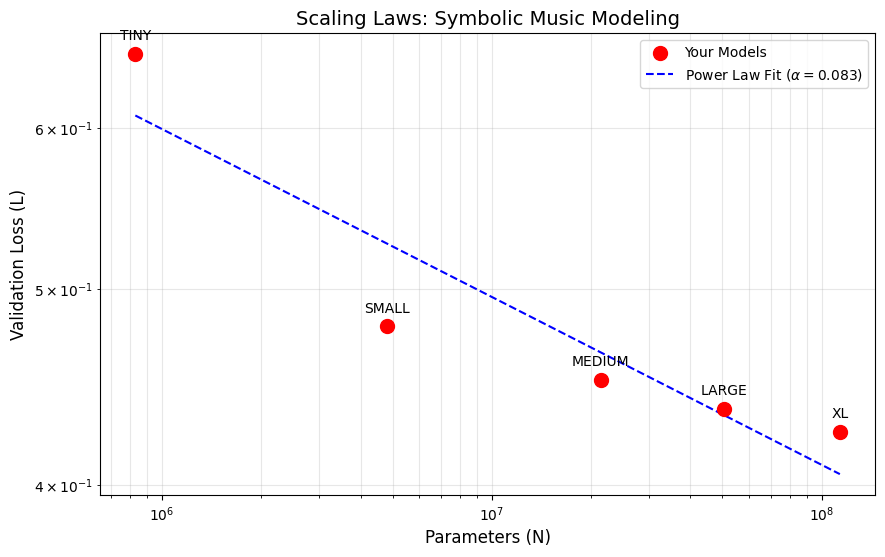

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


results_dir = Path("results")
file1 = results_dir / "scaling_results.json"
file2 = results_dir / "scaling_results_xl.json"

data = []
if file1.exists():
    data.extend(json.load(open(file1)))
if file2.exists():
    data.extend(json.load(open(file2)))



data.sort(key=lambda x: x['params'])

params = np.array([x['params'] for x in data])
losses = np.array([x['val_loss'] for x in data])
configs = [x['config'] for x in data]

print("Model Sizes (Params):", [f"{p/1e6:.1f}M" for p in params])
print("Validation Losses:", losses)




log_params = np.log10(params)
log_losses = np.log10(losses)


slope, intercept = np.polyfit(log_params, log_losses, 1)
alpha = -slope 

print(f"\nCalculated Scaling Exponent (alpha): {alpha:.4f}")
print("   (Theoretical range for text is usually 0.05 - 0.08)")


plt.figure(figsize=(10, 6))


plt.scatter(params, losses, color='red', s=100, zorder=5, label='Your Models')


x_line = np.linspace(min(params), max(params), 100)
y_line = (10**intercept) * (x_line**slope)
plt.plot(x_line, y_line, 'b--', label=f'Power Law Fit ($\\alpha={alpha:.3f}$)')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Parameters (N)', fontsize=12)
plt.ylabel('Validation Loss (L)', fontsize=12)
plt.title('Scaling Laws: Symbolic Music Modeling', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()


for i, txt in enumerate(configs):
    plt.annotate(txt.upper(), (params[i], losses[i]),
                 xytext=(0, 10), textcoords='offset points', ha='center')

plt.savefig("results/scaling_law_plot.png")
plt.show()

In [ ]:
%%writefile src/model_rnn.py
import torch
import torch.nn as nn
from torch.nn import functional as F

class RNNModel(nn.Module):
    """
    A standard LSTM-based language model.
    Designed to mimic the interface of our GPT class for easy swapping.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config

        
        self.token_embedding = nn.Embedding(config.vocab_size, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)

        
        
        
        self.lstm = nn.LSTM(
            input_size=config.n_embd,
            hidden_size=config.n_embd,
            num_layers=config.n_layer,
            batch_first=True,
            dropout=config.dropout if config.n_layer > 1 else 0
        )

        
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size)

        
        self.token_embedding.weight = self.lm_head.weight

        print(f"RNN Initialized: {self.get_num_params()/1e6:.2f}M params")

    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())

    def forward(self, idx, targets=None):
        device = idx.device

        
        x = self.token_embedding(idx)
        x = self.dropout(x)

        
        
        
        output, _ = self.lstm(x)

        
        logits = self.lm_head(output)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

Writing src/model_rnn.py


In [ ]:
%%writefile src/config_rnn.py
from dataclasses import dataclass

@dataclass
class RNNConfig:
    n_layer: int    
    n_embd: int     
    vocab_size: int = 64
    dropout: float = 0.1
    
    block_size: int = 256






RNN_TINY = RNNConfig(n_layer=2, n_embd=256)


RNN_SMALL = RNNConfig(n_layer=2, n_embd=560)


RNN_MEDIUM = RNNConfig(n_layer=2, n_embd=1100)


RNN_LARGE = RNNConfig(n_layer=2, n_embd=1750)

RNN_CONFIGS = {
    "tiny": RNN_TINY,
    "small": RNN_SMALL,
    "medium": RNN_MEDIUM,
    "large": RNN_LARGE
}

Writing src/config_rnn.py


In [ ]:
%%writefile src/train_rnn.py
import torch
from torch.utils.data import Dataset, DataLoader
import time
import json
import pickle
from pathlib import Path


from config_rnn import RNN_CONFIGS
from model_rnn import RNNModel


DATA_DIR = Path("data")
TRAIN_PATH = DATA_DIR / "processed/train_colab.txt"
VAL_PATH = DATA_DIR / "processed/val.txt"
RESULTS_FILE = Path("results/rnn_results.json")


MAX_TRAIN_TOKENS = 100_000_000
BATCH_SIZE = 64
BLOCK_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


class TextDataset(Dataset):
    def __init__(self, path, stoi, block_size, max_length=None):
        self.stoi = stoi
        self.block_size = block_size
        print(f"Loading data from {path}...")
        with open(path, 'r', encoding='utf-8') as f:
            if max_length:
                self.data = f.read(max_length)
            else:
                self.data = f.read()
        self.ids = [self.stoi.get(c, 0) for c in self.data]
        self.ids = torch.tensor(self.ids, dtype=torch.long)

    def __len__(self):
        return len(self.ids) - self.block_size

    def __getitem__(self, idx):
        chunk = self.ids[idx : idx + self.block_size + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y

def train_one_epoch(model, train_loader, val_loader, config_name):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) 
    model.train()
    start_time = time.time()
    total_loss = 0
    steps = 0

    
    tokens_per_step = BATCH_SIZE * BLOCK_SIZE
    max_steps = MAX_TRAIN_TOKENS // tokens_per_step

    print(f"--- Training RNN: {config_name} (Target: {max_steps} steps) ---")

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits, loss = model(x, y)

        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        steps += 1

        if steps % 100 == 0:
            print(f"Step {steps}/{max_steps}: Loss {loss.item():.4f}")

        if steps >= max_steps:
            break

    avg_train_loss = total_loss / steps
    duration = time.time() - start_time

    print("Running Validation...")
    model.eval()
    val_loss = 0
    val_steps = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            _, loss = model(x, y)
            val_loss += loss.item()
            val_steps += 1
            if val_steps > 200: break

    avg_val_loss = val_loss / val_steps

    return {
        "config": config_name,
        "params": model.get_num_params(),
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "duration_sec": duration,
        "architecture": "LSTM"
    }

def main():
    
    print("Loading vocab...")
    with open(DATA_DIR / "processed/vocab.pkl", "rb") as f:
        vocab_data = pickle.load(f)
        stoi = vocab_data["stoi"]
        vocab_size = len(vocab_data["vocab"])

    
    print("Preparing Datasets...")
    train_dataset = TextDataset(TRAIN_PATH, stoi, BLOCK_SIZE, max_length=MAX_TRAIN_TOKENS)
    val_dataset = TextDataset(VAL_PATH, stoi, BLOCK_SIZE, max_length=1_000_000)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    results = []

    
    RESULTS_FILE.parent.mkdir(parents=True, exist_ok=True)
    (DATA_DIR.parent / "checkpoints_rnn").mkdir(exist_ok=True)

    
    model_names = ["tiny", "small", "medium", "large"]

    for name in model_names:
        print(f"\n\n=== Training LSTM Model: {name.upper()} ===")

        
        config = RNN_CONFIGS[name]
        config.vocab_size = vocab_size
        model = RNNModel(config).to(DEVICE)

        
        stats = train_one_epoch(model, train_loader, val_loader, name)
        results.append(stats)

        
        with open(RESULTS_FILE, 'w') as f:
            json.dump(results, f, indent=4)
        print(f"-> Updated {RESULTS_FILE}")

        
        checkpoint_path = DATA_DIR.parent / "checkpoints_rnn" / f"lstm_{name}.pt"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"-> Saved model to {checkpoint_path}")

        del model
        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()

Writing src/train_rnn.py


In [ ]:
!python src/train_rnn.py

Loading vocab...
Preparing Datasets...
Loading data from data/processed/train_colab.txt...
Loading data from data/processed/val.txt...


=== Training LSTM Model: TINY ===
RNN Initialized: 1.07M params
--- Training RNN: tiny (Target: 6103 steps) ---
Step 100/6103: Loss 2.3592
Step 200/6103: Loss 0.5782
Step 300/6103: Loss 0.5320
Step 400/6103: Loss 0.6649
Step 500/6103: Loss 0.3110
Step 600/6103: Loss 0.2529
Step 700/6103: Loss 0.2251
Step 800/6103: Loss 0.2411
Step 900/6103: Loss 0.2054
Step 1000/6103: Loss 0.3099
Step 1100/6103: Loss 0.4218
Step 1200/6103: Loss 0.2977
Step 1300/6103: Loss 0.3521
Step 1400/6103: Loss 0.2738
Step 1500/6103: Loss 0.2285
Step 1600/6103: Loss 0.3061
Step 1700/6103: Loss 0.3151
Step 1800/6103: Loss 0.2326
Step 1900/6103: Loss 0.2231
Step 2000/6103: Loss 0.3385
Step 2100/6103: Loss 0.1228
Step 2200/6103: Loss 0.1940
Step 2300/6103: Loss 0.2690
Step 2400/6103: Loss 0.1956
Step 2500/6103: Loss 0.1601
Step 2600/6103: Loss 0.1692
Step 2700/6103: Loss 0.2066
Step

In [ ]:
%%writefile src/finish_rnn_xl.py
import torch
from torch.utils.data import Dataset, DataLoader
import time
import json
import pickle
from pathlib import Path


from config_rnn import RNNConfig, RNN_CONFIGS
from model_rnn import RNNModel


DATA_DIR = Path("data")
TRAIN_PATH = DATA_DIR / "processed/train_colab.txt"
VAL_PATH = DATA_DIR / "processed/val.txt"
RESULTS_FILE = Path("results/rnn_results_xl.json")





RNN_XL_CONFIG = RNNConfig(n_layer=2, n_embd=2500)


MAX_TRAIN_TOKENS = 100_000_000
BATCH_SIZE = 64
BLOCK_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


class TextDataset(Dataset):
    def __init__(self, path, stoi, block_size, max_length=None):
        self.stoi = stoi
        self.block_size = block_size
        print(f"Loading data from {path}...")
        with open(path, 'r', encoding='utf-8') as f:
            if max_length:
                self.data = f.read(max_length)
            else:
                self.data = f.read()
        self.ids = [self.stoi.get(c, 0) for c in self.data]
        self.ids = torch.tensor(self.ids, dtype=torch.long)

    def __len__(self):
        return len(self.ids) - self.block_size

    def __getitem__(self, idx):
        chunk = self.ids[idx : idx + self.block_size + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y

def train_one_epoch(model, train_loader, val_loader, config_name):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    model.train()
    start_time = time.time()
    total_loss = 0
    steps = 0
    tokens_per_step = BATCH_SIZE * BLOCK_SIZE
    max_steps = MAX_TRAIN_TOKENS // tokens_per_step

    print(f"--- Training RNN: {config_name} (Target: {max_steps} steps) ---")

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits, loss = model(x, y)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        steps += 1

        if steps % 100 == 0:
            print(f"Step {steps}/{max_steps}: Loss {loss.item():.4f}")

        if steps >= max_steps:
            break

    avg_train_loss = total_loss / steps
    duration = time.time() - start_time

    print("Running Validation...")
    model.eval()
    val_loss = 0
    val_steps = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            _, loss = model(x, y)
            val_loss += loss.item()
            val_steps += 1
            if val_steps > 200: break

    avg_val_loss = val_loss / val_steps

    return {
        "config": config_name,
        "params": model.get_num_params(),
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "duration_sec": duration,
        "architecture": "LSTM"
    }

def main():
    
    print("Loading vocab...")
    with open(DATA_DIR / "processed/vocab.pkl", "rb") as f:
        vocab_data = pickle.load(f)
        stoi = vocab_data["stoi"]
        vocab_size = len(vocab_data["vocab"])

    
    print("Preparing Datasets...")
    train_dataset = TextDataset(TRAIN_PATH, stoi, BLOCK_SIZE, max_length=MAX_TRAIN_TOKENS)
    val_dataset = TextDataset(VAL_PATH, stoi, BLOCK_SIZE, max_length=1_000_000)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    
    name = "xl"
    print(f"\n=== Training LSTM Model: {name.upper()} ===")

    
    config = RNN_XL_CONFIG
    config.vocab_size = vocab_size
    model = RNNModel(config).to(DEVICE)

    
    stats = train_one_epoch(model, train_loader, val_loader, name)

    
    with open(RESULTS_FILE, 'w') as f:
        json.dump([stats], f, indent=4)
    print(f"-> Updated {RESULTS_FILE}")

    
    checkpoint_dir = DATA_DIR.parent / "checkpoints_rnn"
    checkpoint_dir.mkdir(parents=True, exist_ok=True)

    checkpoint_path = checkpoint_dir / f"lstm_{name}.pt"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"-> Saved model to {checkpoint_path}")

if __name__ == "__main__":
    main()

Writing src/finish_rnn_xl.py


In [ ]:
!python src/finish_rnn_xl.py

Loading vocab...
Preparing Datasets...
Loading data from data/processed/train_colab.txt...
Loading data from data/processed/val.txt...

=== Training LSTM Model: XL ===
RNN Initialized: 100.20M params
--- Training RNN: xl (Target: 6103 steps) ---
Step 100/6103: Loss 0.5819
Step 200/6103: Loss 0.2993
Step 300/6103: Loss 0.3366
Step 400/6103: Loss 0.2177
Step 500/6103: Loss 0.1913
Step 600/6103: Loss 0.1732
Step 700/6103: Loss 0.1822
Step 800/6103: Loss 0.1720
Step 900/6103: Loss 0.2816
Step 1000/6103: Loss 0.1855
Step 1100/6103: Loss 0.1256
Step 1200/6103: Loss 0.2016
Step 1300/6103: Loss 0.1265
Step 1400/6103: Loss 0.2441
Step 1500/6103: Loss 0.1613
Step 1600/6103: Loss 0.2170
Step 1700/6103: Loss 0.2032
Step 1800/6103: Loss 0.1390
Step 1900/6103: Loss 0.1790
Step 2000/6103: Loss 0.1451
Step 2100/6103: Loss 0.1276
Step 2200/6103: Loss 0.1367
Step 2300/6103: Loss 0.1430
Step 2400/6103: Loss 0.1570
Step 2500/6103: Loss 0.1277
Step 2600/6103: Loss 0.1054
Step 2700/6103: Loss 0.1200
Step 28

Transformer Scaling Exponent (alpha): 0.0828
LSTM Scaling Exponent (alpha):        0.0313


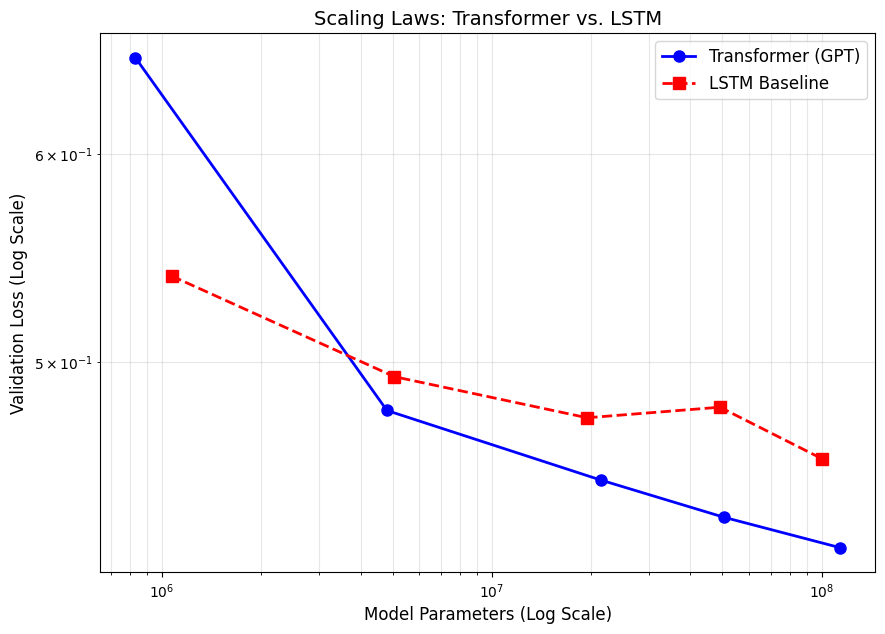

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


results_dir = Path("results")


gpt_data = []
if (results_dir / "scaling_results.json").exists():
    gpt_data.extend(json.load(open(results_dir / "scaling_results.json")))
if (results_dir / "scaling_results_xl.json").exists():
    gpt_data.extend(json.load(open(results_dir / "scaling_results_xl.json")))


rnn_data = []
if (results_dir / "rnn_results.json").exists():
    rnn_data.extend(json.load(open(results_dir / "rnn_results.json")))
if (results_dir / "rnn_results_xl.json").exists():
    rnn_data.extend(json.load(open(results_dir / "rnn_results_xl.json")))


gpt_data.sort(key=lambda x: x['params'])
rnn_data.sort(key=lambda x: x['params'])


gpt_params = np.array([x['params'] for x in gpt_data])
gpt_loss = np.array([x['val_loss'] for x in gpt_data])

rnn_params = np.array([x['params'] for x in rnn_data])
rnn_loss = np.array([x['val_loss'] for x in rnn_data])


plt.figure(figsize=(10, 7))


plt.plot(gpt_params, gpt_loss, 'bo-', linewidth=2, markersize=8, label='Transformer (GPT)')


plt.plot(rnn_params, rnn_loss, 'rs--', linewidth=2, markersize=8, label='LSTM Baseline')



if len(gpt_params) > 1:
    gpt_fit = np.polyfit(np.log10(gpt_params), np.log10(gpt_loss), 1)
    print(f"Transformer Scaling Exponent (alpha): {-gpt_fit[0]:.4f}")

if len(rnn_params) > 1:
    rnn_fit = np.polyfit(np.log10(rnn_params), np.log10(rnn_loss), 1)
    print(f"LSTM Scaling Exponent (alpha):        {-rnn_fit[0]:.4f}")


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Model Parameters (Log Scale)', fontsize=12)
plt.ylabel('Validation Loss (Log Scale)', fontsize=12)
plt.title('Scaling Laws: Transformer vs. LSTM', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend(fontsize=12)


plt.savefig("results/comparison_plot.png")
plt.show()

In [ ]:
%%writefile src/generate.py
import torch
import pickle
from pathlib import Path
import torch.nn.functional as F


from config import MODEL_CONFIGS
from model import GPT


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CHECKPOINT_PATH = Path("data/checkpoints/gpt_xl.pt")
VOCAB_PATH = Path("data/processed/vocab.pkl")
NUM_SAMPLES = 1  

def generate(model, idx, max_new_tokens, temperature=0.8, top_k=200):
    """
    Generates new tokens using top-k sampling.
    temperature: Higher (1.0) = more creative/chaotic. Lower (0.5) = more predictable.
    top_k: Restricts sampling to the top k most likely next characters.
    """
    for _ in range(max_new_tokens):
        
        idx_cond = idx[:, -model.config.block_size:]

        
        logits, _ = model(idx_cond)
        
        logits = logits[:, -1, :] / temperature

        
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')

        
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)

        
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

def main():
    
    print("Loading vocab...")
    with open(VOCAB_PATH, 'rb') as f:
        vocab_data = pickle.load(f)
        stoi = vocab_data["stoi"]
        itos = vocab_data["itos"]

    
    print("Loading XL Model...")
    config = MODEL_CONFIGS["xl"]
    config.vocab_size = len(stoi)

    model = GPT(config).to(DEVICE)
    state_dict = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.eval()
    print("Model loaded successfully!")

    
    
    

    seeds = [
        "X:1\nM:4/4\nL:1/8\nK:C\nV:1\nc2",       
        "X:2\nM:4/4\nL:1/8\nK:C\nV:1\n[FA]2",    
        "X:3\nM:4/4\nL:1/8\nK:C\nV:1\nz4 G2",    
        "X:4\nM:4/4\nL:1/8\nK:C\nV:1\n^F2",      
        "X:5\nM:4/4\nL:1/8\nK:C\nV:1\nG,2 B,2"   
    ]

    print(f"\n--- Generating {len(seeds)} Diverse Samples ---\n")

    for i, prompt_str in enumerate(seeds):
        context = [stoi.get(c, 0) for c in prompt_str]
        context_tensor = torch.tensor(context, dtype=torch.long, device=DEVICE).unsqueeze(0)

        
        out_ids = generate(model, context_tensor, max_new_tokens=600, temperature=1.0)

        generated_text = "".join([itos[i] for i in out_ids[0].tolist()])

        print(f"SAMPLE {i+1} (Seed: {prompt_str[-3:]}):")
        print("="*40)
        print(generated_text)
        print("="*40 + "\n")

        
        save_path = Path("results") / f"generated_sample_{i+1}.abc"
        with open(save_path, "w") as f:
            f.write(generated_text)

    print("Generation Complete. Copy the ABC text to https://abcjs.net/ abc-editor.html to hear it!")

if __name__ == "__main__":
    main()

Overwriting src/generate.py


In [ ]:
!python src/generate.py

Loading vocab...
Loading XL Model...
Model initialized: 113.54M parameters
Model loaded successfully!

--- Generating 5 Diverse Samples ---

SAMPLE 1 (Seed: 
c2):
X:1
M:4/4
L:1/8
K:C
V:1
c2c/2a/2| \
g3-g/2-[g=c^A]2d/2-| \
d4 cc| \
zB f2c|
c^A c=A| \
cc e2=c| \
c4- cc| \
cz6z|
z6 cc| \
zB f2-f/2e/2 c/2zcz/2| \
z6| \
zG g2 d2 fE,|
=F,D, =A,B, CC| \
[G,B,]2 [=GC]2| \
[C-G,-C,-]6 [CG,C,]3/2[CCG,]/2| \
z6 z3/2D/2|
z/2G/2G/2z/2 gd E2 E/2z3z/2| \
z6 C/2z3/2| \
C/2z/2D/2z/2 c/2z/2G/2z/2 CC-[CG,]/2z/2 B,3/2D/2| \
E2- [EC-G,-]/2[CG,]/2C/2z/2 DC-|
C3-C/2z6z/2| \
z8| \
D3/2d/2 eA cd| \
e2 d2 z2|
d2 z6| \
z8| \
z8| \
z8|
z8| \
z8| \
z8| \
z8|
zB, BB, ^AB, ^A3B,| \
C/2z/2D ED ED CE,-| \
EE EE,- E2 CE,-| \
EE, DE E2 DE,-|
EE, DE, DE, DE,-| \
EE, DE, DE EE,-| \
E,E, DE D^F, DE, DE,-| \
E,[DE,-]

SAMPLE 2 (Seed: A]2):
X:2
M:4/4
L:1/8
K:C
V:1
[FA]2 [FA,]2 [GG,]2 [GG,]2| \
[GG,]4 [GG,]2 [GG,]2| \
[GG,]4 [GG,]2 [AG,]2| \
[GG,]4 [GG,]2 [GG,]2|
[GG,]4 [GG,]2 [GG,]2| \
[GG,]4 [GG,]6| \
[GG,]4 [GG,]4| \
[GG,]

In [ ]:
!python src/generate.py

Loading vocab...
Loading XL Model...
Model initialized: 113.54M parameters
Model loaded successfully!

--- Prompting with: ---
X:1
M:4/4
L:1/8
K:C

--- Generating 1 Samples ---

SAMPLE 1:
X:1
M:4/4
L:1/8
K:C
 % 3 flats
V:1
z8| \
z8| \
z8| \
z8|
z8| \
[F-D-]4 [FD-][FD] [FD][FD]/2z/2| \
[F-D-]4 [FD][FD] [FD]2| \
[FD]4 [FD]4|
[F-D-]4 [FD][FD] [FD][FD]| \
[FD]4 [FD]4| \
[FD]4 [FD]4| \
[G-D-]4 [GD][GD] [GD]2|
[G-C-]4 [GC][GC] [GC][GC]| \
[G-D-]4 [GD][GD] [GD]2| \
[G-C-]4 [GC][GC] [GD]2| \
[G-C-]2 [GC][GC] [GC]2 [GC]2|
[G-C-]4 [GC][GC] [GC][GC]| \
[GC]4 [G-C]2 [GC][GC]| \
[GC]4 [GC]2 [GC][GC]| \
[G-C-]4 [GC][GC] [GC]2|
[G-C-]4 [GC][GC] [GC]2| \
[G-C-]4 [GC][GC] [GC][GC]| \
[G-C-]4 [GC][GC] [GC][GC]| \
[G-



In [ ]:
!pip install music21

In [ ]:
%%writefile src/evaluate_best.py
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pickle
import json
import math
from pathlib import Path
from tqdm import tqdm
import music21
import os


from config import MODEL_CONFIGS
from model import GPT


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = Path("data")

TEST_PATH = DATA_DIR / "processed/val.txt"
CHECKPOINT_PATH = DATA_DIR / "checkpoints/gpt_xl.pt"
VOCAB_PATH = DATA_DIR / "processed/vocab.pkl"


NUM_SAMPLES = 20  
MAX_NEW_TOKENS = 512


class TextDataset(Dataset):
    def __init__(self, path, stoi, block_size):
        self.stoi = stoi
        self.block_size = block_size
        print(f"Loading evaluation data from {path}...")
        with open(path, 'r', encoding='utf-8') as f:
            self.data = f.read()
        self.ids = [self.stoi.get(c, 0) for c in self.data]
        self.ids = torch.tensor(self.ids, dtype=torch.long)

    def __len__(self):
        return len(self.ids) - self.block_size

    def __getitem__(self, idx):
        chunk = self.ids[idx : idx + self.block_size + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y

def calculate_perplexity(model, loader):
    """
    Calculates Perplexity = exp(CrossEntropyLoss)
    """
    model.eval()
    total_loss = 0
    total_steps = 0

    print("Calculating Perplexity on Test Set...")
    with torch.no_grad():
        for x, y in tqdm(loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            _, loss = model(x, y)
            total_loss += loss.item()
            total_steps += 1

    avg_loss = total_loss / total_steps
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity

def check_validity(abc_string):
    """
    Tries to parse ABC string with music21.
    Returns (is_valid, midi_object_or_none)
    """
    
    try:
        
        
        
        s = music21.converter.parseData(abc_string)
        return True, s
    except Exception as e:
        return False, None

def generate_sample(model, stoi, itos, prompt="X:1\nM:4/4\nL:1/8\nK:C\nV:1\n"):
    context = [stoi.get(c, 0) for c in prompt]
    x = torch.tensor(context, dtype=torch.long, device=DEVICE).unsqueeze(0)

    generated = []
    model.eval()
    for _ in range(MAX_NEW_TOKENS):
        x_cond = x[:, -model.config.block_size:]
        logits, _ = model(x_cond)
        logits = logits[:, -1, :]

        
        logits = logits / 1.0
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        x = torch.cat((x, next_token), dim=1)
        char = itos[next_token.item()]
        generated.append(char)

        
        if len(generated) > 2 and generated[-1] == '\n' and generated[-2] == '\n':
            break

    return prompt + "".join(generated)


def main():
    
    with open(VOCAB_PATH, 'rb') as f:
        v = pickle.load(f)
        stoi, itos = v["stoi"], v["itos"]

    
    config = MODEL_CONFIGS["xl"]
    config.vocab_size = len(stoi)
    model = GPT(config).to(DEVICE)
    model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
    model.eval()
    print("Model loaded.")

    
    
    ds = TextDataset(TEST_PATH, stoi, config.block_size)
    
    loader = DataLoader(ds, batch_size=32, shuffle=False)

    test_loss, perplexity = calculate_perplexity(model, loader)
    print(f"\nRESULTS:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Perplexity: {perplexity:.4f}")

    
    print(f"\nGenerating {NUM_SAMPLES} samples for validity check...")
    valid_count = 0
    midi_count = 0

    output_dir = Path("results/generated_midi")
    output_dir.mkdir(parents=True, exist_ok=True)

    for i in range(NUM_SAMPLES):
        
        song = generate_sample(model, stoi, itos, prompt=f"X:{i+1}\nM:4/4\nL:1/8\nK:C\nV:1\nz4 c2")

        
        is_valid, score = check_validity(song)

        if is_valid:
            valid_count += 1
            
            try:
                midi_path = output_dir / f"sample_{i+1}.mid"
                score.write('midi', fp=midi_path)
                midi_count += 1
            except:
                pass

    print(f"\nQUANTITATIVE METRICS:")
    print(f"Syntactically Valid ABC: {valid_count}/{NUM_SAMPLES} ({valid_count/NUM_SAMPLES*100:.1f}%)")
    print(f"Convertible to MIDI:     {midi_count}/{NUM_SAMPLES} ({midi_count/NUM_SAMPLES*100:.1f}%)")

    
    metrics = {
        "test_loss": test_loss,
        "perplexity": perplexity,
        "validity_pct": valid_count/NUM_SAMPLES,
        "midi_conversion_pct": midi_count/NUM_SAMPLES
    }
    with open("results/best_model_metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)
    print("Metrics saved to results/best_model_metrics.json")

if __name__ == "__main__":
    main()

Overwriting src/evaluate_best.py


In [ ]:
!python src/evaluate_best.py

Model initialized: 113.54M parameters
Model loaded.
Loading evaluation data from data/processed/val.txt...
Calculating Perplexity on Test Set...
  1% 16618/1264952 [37:01<46:21:35,  7.48it/s]
Traceback (most recent call last):
  File "/content/drive/MyDrive/MusicScalingProject/src/evaluate_best.py", line 176, in <module>
    main()
  File "/content/drive/MyDrive/MusicScalingProject/src/evaluate_best.py", line 130, in main
    test_loss, perplexity = calculate_perplexity(model, loader)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/MusicScalingProject/src/evaluate_best.py", line 61, in calculate_perplexity
    total_loss += loss.item()
                  ^^^^^^^^^^^
KeyboardInterrupt
^C
